<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Name-Biswajit gorai ,Roll no- MA24M005

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bgorai005 (bgorai005-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


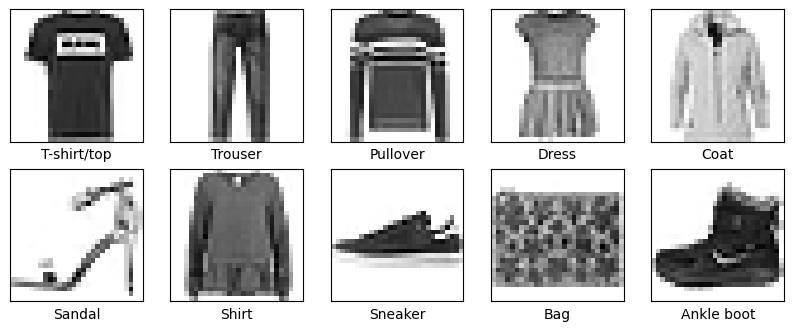

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning_assignment_1',name='dataset_sample1',mode='online')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"examples":[wandb.Image(train_images[i],caption=class_labels[train_labels[i]])for i in range(10)]})
# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()
#594642013968a68e466138e783dcece6765c43b9

In [5]:
from sklearn.model_selection import train_test_split

def tranform_dataset(train_images,train_labels,test_images,test_labels):
  #split the training dataset for traning and validation
  x_train,x_valid,y_train,y_valid=train_test_split(train_images,train_labels,test_size=0.1,random_state=42)
   #flattenten the image data
  x_train = x_train.reshape(x_train.shape[0], -1)
  x_valid = x_valid.reshape(x_valid.shape[0], -1)
  x_test = test_images.reshape(test_images.shape[0], -1)
  #Normalize the image data
  x_train = x_train.astype('float32') / 255
  x_valid = x_valid.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # one hot encode for output column
  y_train = one_hot_encode(y_train)
  y_valid = one_hot_encode(y_valid)
  y_test = one_hot_encode(test_labels)


  return x_train,y_train,x_valid,y_valid,x_test,y_test



#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded


In [6]:
#transform the dataset for using the feedforward neural network models
x_train,y_train,x_valid,y_valid,x_test,y_test=tranform_dataset(train_images,train_labels,test_images,test_labels)

In [7]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


Intialize a network

In [8]:
import numpy as np

def initial_weight(num_layer, hidden_size, weight_ini_method):
    # Create a list with num_layer hidden layers, each of size hidden_size
    network_size = [hidden_size] * num_layer
    # Prepend input size and append output size
    network_size = [x_train.shape[1]] + network_size + [y_train.shape[1]]
    print(network_size)  # Print the network architecture for debugging

    # Initialize an empty dictionary to store weights and biases
    theta = {}

    # Random initialization
    if weight_ini_method == "random":
        for i in range(len(network_size) - 1):
            # Weights: shape (current layer size, next layer size)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1])
            # Biases: shape (1, next layer size)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1])

    # Xavier (He-like) initialization
    elif weight_ini_method == "Xavier":
        for i in range(len(network_size) - 1):
            # Scaling factor based on input size (fan-in)
            scale = np.sqrt(2 / network_size[i])
            # Weights: random normal scaled by sqrt(2 / fan-in)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1]) * scale
            # Biases: random normal scaled by sqrt(2 / fan-in)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1]) * scale

    # Return the initialized parameters
    return theta

*Activation functiont**

In [9]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [10]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss
def mse_loss(y_actual,y_pred):
  return np.mean((y_actual-y_pred)**2)


def deriv_cross_entropy(y_actual,y_pred):
    return (y_pred-y_actual)
def deriv_mse_loss(y_actual, y_pred):
    return (y_pred - y_actual) * y_pred * (1 - y_pred)


def loss_derivative(y_actual,y_pred,loss_function):
  if loss_function=='cross_entropy':
    return deriv_cross_entropy
  else:
    return deriv_mse_loss



Forward Propagation

In [11]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


Calculate accuracy

In [12]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [13]:
def back_prop(x, y, theta, active_fun_hidden, active_fun_output, num_layers, loss_function):
    m = x.shape[0]
    a, h, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
    grad_theta = {}
    grad_h_a = {}

    # Compute loss derivative based on the chosen loss function
    loss_grad = loss_derivative(y, y_pred, loss_function)
    grad_h_a[f'a{num_layers+1}'] = loss_grad(y, y_pred)

    for i in range(num_layers+1, 0, -1):
        grad_theta[f'W{i}'] = np.dot(h[f'h{i-1}'].T, grad_h_a[f'a{i}'])
        grad_theta[f'b{i}'] = np.sum(grad_h_a[f'a{i}'], axis=0, keepdims=True)

        if i > 1:
            grad_h_a[f'h{i-1}'] = np.dot(grad_h_a[f'a{i}'], theta[f'W{i}'].T)
            grad_h_a[f'a{i-1}'] = grad_h_a[f'h{i-1}'] * deriv_activation(a[f'a{i-1}'], active_fun_hidden)

    return grad_theta


Now we again write gradient decesent algorithm compatiable with batch size ,

In [14]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Val Accuracy:{ validation_accuracy}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [15]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta


**Nesterov accelerated gradient descent**

In [16]:
def nesterov_gd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entorpy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update velocities and parameters with Nesterov momentum and apply weight decay
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}'] + weight_decay * theta[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity (no weight decay for biases)
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss and predictions
        a, h, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100,'epoch':epoch+1})

    return theta

**RMS Prop**

In [17]:
def rmsprop(lr, gamma, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update squared gradients and parameters using RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Apply weight decay separately (L2 Regularization)
                theta[f'W{k}'] -= lr * (grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon)) + weight_decay * theta[f'W{k}']

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases
                theta[f'b{k}'] -= lr * (grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon))

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        val_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2%}, Val Acc: {val_accuracy:.2%}")

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy * 100,
            "val_accuracy": val_accuracy * 100
        })

    return theta


**ADAM**

In [18]:
def adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**NDAM**

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train, y_train = x_train[indices], y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss}, validation_accuracy:{ validation_accuracy}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**MOdel **

In [20]:
def model_training(lr, beta, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, optimizer, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function):

    if optimizer == 'sgd':
        theta = sgd(lr, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'momentum':
        theta = mgd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'nag':
        theta = nesterov_gd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'RMSprop':
        theta = rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'adam':
        theta = adam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer=='nadam':
      theta=nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    return theta

In [54]:
#Q2 and Q3 train a neural network with given hypermaters with cross entropy loss
#in question 2 intialize a neural network and pass a forward prop that will predict probabilities. here i run adam model , in there first it create
#a intial network and call backprop update weights , in back prop at first it will call forward prop then update weights and it will iterate as many epochs it has
#and give the accuracy, loss for train and valid dataset.
#---------uncomment the below code for run----------------
#wandb.init(project='deep_learning_assignment_1',name='adam-relu-softmax-random-layer-4-hid_size-32-epoch-5'')
#theta=adam(0.001,0.9,0.99,1e-8,x_train, y_train, x_valid, y_valid,32,4,'relu','softmax','random',0,5)
#wandb.finish()


In [55]:
#Q4 : create a sweep_id and run the sweep in wandb and generate all the required plots.
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: i8bhmt8c
Sweep URL: https://wandb.ai/bgorai005-iit-madras/deep_learning_assignment_1/sweeps/i8bhmt8c


In [ ]:
#Q4: main function

def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'cross_entropy')

try:
    wandb.agent(sweep_id,function=main,count=100)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.3514489661786835, Validation Loss: 0.370225922334888
Epoch 2, Loss: 0.2978939068113735, Validation Loss: 0.33196157329096476
Epoch 3, Loss: 0.2823917371358681, Validation Loss: 0.32643137307740727
Epoch 4, Loss: 0.255799436183171, Validation Loss: 0.3100039498893626
Epoch 5, Loss: 0.24369466308336896, Validation Loss: 0.30798820765461754
Epoch 6, Loss: 0.22602214828983472, Validation Loss: 0.30245448798928604
Epoch 7, Loss: 0.26465270071193525, Validation Loss: 0.3509802844097199
Epoch 8, Loss: 0.22134766425749908, Validation Loss: 0.3162254388555397
Epoch 9, Loss: 0.20388124998460014, Validation Loss: 0.30735019086158955
Epoch 10, Loss: 0.18860551174315185, Validation Loss: 0.2959032197598829


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▅▆▇█
train_loss,█▆▅▄▃▃▄▂▂▁
val_accuracy,▁▅▅▇▇█▅▆▇█
val_loss,█▄▄▂▂▂▆▃▂▁
epoch,10
train_accuracy,93.1
train_loss,0.18861
val_accuracy,89.45
val_loss,0.2959


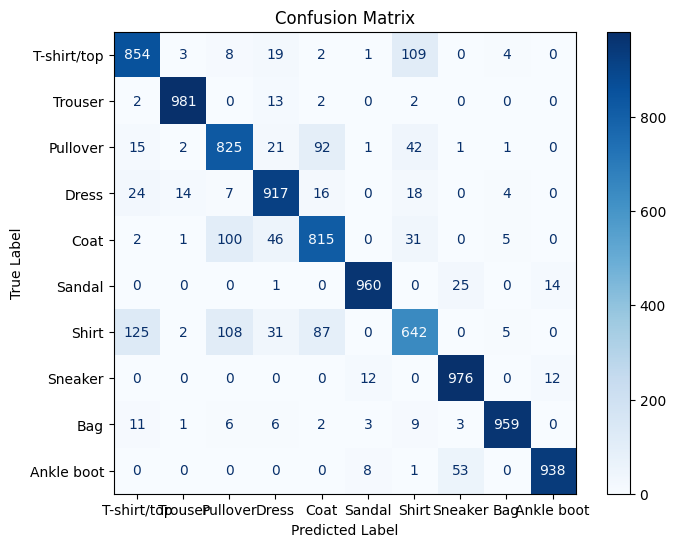

In [21]:
#Q7:From the above results, we found that Nadam achieved the highest accuracy of 89.5% with the following hyperparameters: activation = ReLU, layers = 3, hidden size = 128, initialization = Xavier, epochs = 10, batch size = 64.

#To generate the confusion matrix for the best model, we first retrieve the corresponding theta values, perform forward propagation to obtain y_pred,
# and then use these predictions to create the confusion matrix.

# Initialize W&B run
wandb.init(project='deep_learning_assignment_1', name='confusion_matrix_run')
theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,64,3,128,'tanh','softmax','Xavier',0,10)
y_test_label=[]
y_test_pred_label=[]
m=x_test.shape[0]
for i in range(m):
  x_tes =x_test[i,:].reshape(-1,1)
  a,h,y_test_pred=forward_prop(x_tes.T,theta1,'tanh','softmax',3)
  y1=np.argmax(y_test[i,:].reshape(-1,1),axis=0)
  y_test_label.append(y1)
  # Get the index of the maximum probability for the current sample
  y2=np.argmax(y_test_pred)
  # Append only the predicted class label (integer) to the list
  y_test_pred_label.append(y2)
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test_label, y_test_pred_label)
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Log the confusion matrix plot to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()


In [24]:
# question 8 : running a all the models for squared error loss and comapre them with previous one, for that i create another sweep and run all the models .
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: 4uv2tuxd
Sweep URL: https://wandb.ai/bgorai005-iit-madras/deep_learning_assignment_1/sweeps/4uv2tuxd


In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}_loss-{mse_loss}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=100)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: zgwefa02 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.07061223261514078, Val Loss: 0.07048740434630325
Epoch 2, Train Loss: 0.059035730788355376, Val Loss: 0.0589661618354987
Epoch 3, Train Loss: 0.052695736007371305, Val Loss: 0.05287301612997845
Epoch 4, Train Loss: 0.04810932071820406, Val Loss: 0.04818856644624472
Epoch 5, Train Loss: 0.04500168960751937, Val Loss: 0.04509266158707126
Epoch 6, Train Loss: 0.04282074124069874, Val Loss: 0.04298538918177162
Epoch 7, Train Loss: 0.041214002299272474, Val Loss: 0.041438315552373206
Epoch 8, Train Loss: 0.04004967644233066, Val Loss: 0.04029892801292239
Epoch 9, Train Loss: 0.03907686147010186, Val Loss: 0.03943613062608609
Epoch 10, Train Loss: 0.03815769372815575, Val Loss: 0.03852510006201892


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,72.57593
train_loss,0.03816
val_accuracy,72.25
val_loss,0.03853


wandb: Agent Starting Run: 5l5fc8yo with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.17638107252577526, Val Loss: 0.1769917099043421
Epoch 2, Train Loss: 0.1813828270003407, Val Loss: 0.18125670355702658
Epoch 3, Train Loss: 0.18294993890803526, Val Loss: 0.184055643826358
Epoch 4, Train Loss: 0.1777730041248334, Val Loss: 0.17883338261227927
Epoch 5, Train Loss: 0.17905899031085568, Val Loss: 0.18056666666666665


epoch,▁▃▅▆█
train_accuracy,█▃▁▇▅
train_loss,▁▆█▂▄
val_accuracy,█▄▁▆▄
val_loss,▁▅█▃▅
epoch,5
train_accuracy,10.47037
train_loss,0.17906
val_accuracy,9.71667
val_loss,0.18057


wandb: Agent Starting Run: 18jswal6 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.08964947964357059, Val Loss: 0.08965034182645189,Val Accuracy:0.232
Epoch 2, Train Loss: 0.0773062656643512, Val Loss: 0.07756330408388151,Val Accuracy:0.3468333333333333
Epoch 3, Train Loss: 0.07151820468574673, Val Loss: 0.07129631687603828,Val Accuracy:0.4086666666666667
Epoch 4, Train Loss: 0.06706921491797503, Val Loss: 0.06737662616208401,Val Accuracy:0.4658333333333333
Epoch 5, Train Loss: 0.06356419072613198, Val Loss: 0.06370786679969226,Val Accuracy:0.4811666666666667
Epoch 6, Train Loss: 0.06069554836936261, Val Loss: 0.06167982941203894,Val Accuracy:0.49233333333333335
Epoch 7, Train Loss: 0.05888478021238258, Val Loss: 0.059859053484891636,Val Accuracy:0.5245
Epoch 8, Train Loss: 0.05697165878926602, Val Loss: 0.058216505848306545,Val Accuracy:0.529
Epoch 9, Train Loss: 0.05487825179577454, Val Loss: 0.05604886633583522,Val Accuracy:0.5758333333333333
Epoch 10, Train Loss: 0.0530652473827971, Val Loss: 0.0545433405925253

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,59.90185
train_loss,0.05307
val_accuracy,58.03333
val_loss,0.05454


wandb: Agent Starting Run: lvmevum9 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.16279317376823446, Validation Loss: 0.1646999966858455
Epoch 2, Loss: 0.16013905132559805, Validation Loss: 0.16225807365394157
Epoch 3, Loss: 0.16371240130951048, Validation Loss: 0.16476666437213144
Epoch 4, Loss: 0.1515234522145812, Validation Loss: 0.15269236511082934
Epoch 5, Loss: 0.15465742659303755, Validation Loss: 0.15611039385434497


epoch,▁▃▅▆█
train_accuracy,▂▃▁█▆
train_loss,▇▆█▁▃
val_accuracy,▁▂▁█▆
val_loss,█▇█▁▃
epoch,5
train_accuracy,22.66852
train_loss,0.15466
val_accuracy,21.93333
val_loss,0.15611


wandb: Agent Starting Run: zjwefn09 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.0848790054814821, Val Loss: 0.08438117587211451,Val Accuracy:0.2946666666666667
Epoch 2, Train Loss: 0.07741042285277201, Val Loss: 0.07692321315989513,Val Accuracy:0.368
Epoch 3, Train Loss: 0.0725263985004965, Val Loss: 0.07219136848663289,Val Accuracy:0.437
Epoch 4, Train Loss: 0.06858637995808582, Val Loss: 0.06838965721469022,Val Accuracy:0.48283333333333334
Epoch 5, Train Loss: 0.06536686608574013, Val Loss: 0.06534366722596255,Val Accuracy:0.5098333333333334
Epoch 6, Train Loss: 0.06262197615616781, Val Loss: 0.06266351357788974,Val Accuracy:0.5386666666666666
Epoch 7, Train Loss: 0.06029884581521385, Val Loss: 0.06034903940288485,Val Accuracy:0.5536666666666666
Epoch 8, Train Loss: 0.05819087319728694, Val Loss: 0.0582676639008423,Val Accuracy:0.5665
Epoch 9, Train Loss: 0.05647350061514918, Val Loss: 0.05661380131504349,Val Accuracy:0.5746666666666667
Epoch 10, Train Loss: 0.05487379580306793, Val Loss: 0.055058977087167706,Val 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,59.20185
train_loss,0.05487
val_accuracy,58.36667
val_loss,0.05506


wandb: Agent Starting Run: f22h09x5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.027183065308723574, Validation Loss: 0.028822558135808207
Epoch 2, Loss: 0.024026998003480574, Validation Loss: 0.02578411310548269
Epoch 3, Loss: 0.021567143300043785, Validation Loss: 0.023918105923366958
Epoch 4, Loss: 0.020344891122806172, Validation Loss: 0.0229380915550724
Epoch 5, Loss: 0.018868861429408187, Validation Loss: 0.0223640891106344
Epoch 6, Loss: 0.01779851375725016, Validation Loss: 0.02195063151005574
Epoch 7, Loss: 0.017456118976363538, Validation Loss: 0.021915850121591765
Epoch 8, Loss: 0.01691549732556086, Validation Loss: 0.02163080557399049
Epoch 9, Loss: 0.016324745242165237, Validation Loss: 0.021467733276215352
Epoch 10, Loss: 0.015674976933153315, Validation Loss: 0.02098986231526017


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,89.33519
train_loss,0.01567
val_accuracy,85.4
val_loss,0.02099


wandb: Agent Starting Run: mvmth3s2 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.1856, Val Loss: 0.1851, Train Acc: 7.19%, Val Acc: 7.45%
Epoch 2, Loss: 0.1854, Val Loss: 0.1849, Train Acc: 7.32%, Val Acc: 7.55%
Epoch 3, Loss: 0.1847, Val Loss: 0.1847, Train Acc: 7.65%, Val Acc: 7.65%
Epoch 4, Loss: 0.1832, Val Loss: 0.1837, Train Acc: 8.38%, Val Acc: 8.17%
Epoch 5, Loss: 0.1834, Val Loss: 0.1839, Train Acc: 8.31%, Val Acc: 8.05%
Epoch 6, Loss: 0.1826, Val Loss: 0.1829, Train Acc: 8.70%, Val Acc: 8.55%
Epoch 7, Loss: 0.1824, Val Loss: 0.1830, Train Acc: 8.80%, Val Acc: 8.50%
Epoch 8, Loss: 0.1826, Val Loss: 0.1833, Train Acc: 8.71%, Val Acc: 8.35%
Epoch 9, Loss: 0.1829, Val Loss: 0.1835, Train Acc: 8.54%, Val Acc: 8.25%
Epoch 10, Loss: 0.1829, Val Loss: 0.1834, Train Acc: 8.54%, Val Acc: 8.30%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▆▆███▇▇
train_loss,█▇▆▃▃▁▁▁▂▂
val_accuracy,▁▂▂▆▅██▇▆▆
val_loss,█▇▇▃▄▁▁▂▃▃
epoch,10
train_accuracy,8.54259
train_loss,0.18291
val_accuracy,8.3
val_loss,0.1834


wandb: Agent Starting Run: ch4rme07 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.0431, Val Loss: 0.0437, Train Acc: 67.41%, Val Acc: 66.85%
Epoch 2, Loss: 0.0364, Val Loss: 0.0368, Train Acc: 73.50%, Val Acc: 73.20%
Epoch 3, Loss: 0.0334, Val Loss: 0.0342, Train Acc: 76.36%, Val Acc: 75.87%
Epoch 4, Loss: 0.0304, Val Loss: 0.0310, Train Acc: 78.53%, Val Acc: 78.27%
Epoch 5, Loss: 0.0290, Val Loss: 0.0307, Train Acc: 79.65%, Val Acc: 78.45%
Epoch 6, Loss: 0.0284, Val Loss: 0.0296, Train Acc: 79.92%, Val Acc: 78.62%
Epoch 7, Loss: 0.0272, Val Loss: 0.0292, Train Acc: 80.94%, Val Acc: 79.37%
Epoch 8, Loss: 0.0259, Val Loss: 0.0275, Train Acc: 81.87%, Val Acc: 80.65%
Epoch 9, Loss: 0.0258, Val Loss: 0.0278, Train Acc: 81.87%, Val Acc: 80.17%
Epoch 10, Loss: 0.0257, Val Loss: 0.0275, Train Acc: 82.09%, Val Acc: 80.87%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.09259
train_loss,0.02568
val_accuracy,80.86667
val_loss,0.02754


wandb: Agent Starting Run: moy9mp27 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.0682346534974318, Validation Loss: 0.06941787170979645
Epoch 2, Loss: 0.054269760242190754, Validation Loss: 0.05559274221636412
Epoch 3, Loss: 0.047422169069656996, Validation Loss: 0.04864538035871463
Epoch 4, Loss: 0.04297686684734452, Validation Loss: 0.04416630371156046
Epoch 5, Loss: 0.040285164931035206, Validation Loss: 0.04141620088128875


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,71
train_loss,0.04029
val_accuracy,70.08333
val_loss,0.04142


wandb: Agent Starting Run: e1l06kup with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.1549389793331553, Val Loss: 0.15475295950906795,Val Accuracy:0.10816666666666666
Epoch 2, Train Loss: 0.14845685596988395, Val Loss: 0.14952749114391492,Val Accuracy:0.1235
Epoch 3, Train Loss: 0.14150294253833362, Val Loss: 0.14216885602449592,Val Accuracy:0.15216666666666667
Epoch 4, Train Loss: 0.13572104603169705, Val Loss: 0.13820759421782614,Val Accuracy:0.16133333333333333
Epoch 5, Train Loss: 0.13147802999873828, Val Loss: 0.13390326725735763,Val Accuracy:0.1625
Epoch 6, Train Loss: 0.12522539476670913, Val Loss: 0.1255705355718299,Val Accuracy:0.17466666666666666
Epoch 7, Train Loss: 0.11740239355737804, Val Loss: 0.11736131993199239,Val Accuracy:0.18583333333333332
Epoch 8, Train Loss: 0.10861119050007412, Val Loss: 0.10882711410013278,Val Accuracy:0.2005
Epoch 9, Train Loss: 0.10064700018849786, Val Loss: 0.10128240985973355,Val Accuracy:0.20883333333333334
Epoch 10, Train Loss: 0.09461840359478978, Val Loss: 0.095350464330034

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▅▅▆▆▇█
train_loss,█▇▆▆▅▅▄▃▂▁
val_accuracy,▁▂▄▄▄▅▆▇▇█
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
train_accuracy,23.01852
train_loss,0.09462
val_accuracy,22.51667
val_loss,0.09535


wandb: Agent Starting Run: e7snd55y with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.1386355700455411, Validation Loss: 0.13753629895168512
Epoch 2, Loss: 0.1394216585845618, Validation Loss: 0.13982928217600835
Epoch 3, Loss: 0.1296957070013187, Validation Loss: 0.12904432457435233
Epoch 4, Loss: 0.12025296149509968, Validation Loss: 0.12023290932279136
Epoch 5, Loss: 0.11263743150580748, Validation Loss: 0.112308927715579
Epoch 6, Loss: 0.10825806544664293, Validation Loss: 0.1078263825068997
Epoch 7, Loss: 0.10336362457546901, Validation Loss: 0.10309557747808439
Epoch 8, Loss: 0.10186554178625054, Validation Loss: 0.10165613786670573
Epoch 9, Loss: 0.09943215159664734, Validation Loss: 0.09922684621702046
Epoch 10, Loss: 0.09683781699335957, Validation Loss: 0.09670031651411783


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▁▇▆▅▄▄▄▄
train_loss,██▆▅▄▃▂▂▁▁
val_accuracy,█▃▁▆▇▅▄▄▄▄
val_loss,██▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,10.0037
train_loss,0.09684
val_accuracy,10.21667
val_loss,0.0967


wandb: Agent Starting Run: 6jh83c68 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.028359658382367387, Validation Loss: 0.029439944913000112
Epoch 2, Loss: 0.024354764370570218, Validation Loss: 0.026540056318064862
Epoch 3, Loss: 0.02262352366989992, Validation Loss: 0.025038262171745436
Epoch 4, Loss: 0.021510718074722594, Validation Loss: 0.02454491830995104
Epoch 5, Loss: 0.020157614760202017, Validation Loss: 0.02360694875433311


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,86.23889
train_loss,0.02016
val_accuracy,83.46667
val_loss,0.02361


wandb: Agent Starting Run: cvlufp6j with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 2, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 3, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 4, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 5, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 6, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 7, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 8, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 9, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335
Epoch 10, Loss: 0.17996296296296296, Validation Loss: 0.18033333333333335


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.01852
train_loss,0.17996
val_accuracy,9.83333
val_loss,0.18033


wandb: Agent Starting Run: c9hzui9q with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.022823382820478414, Validation Loss: 0.02379775582148959
Epoch 2, Loss: 0.021288149945393128, Validation Loss: 0.02243369068552305
Epoch 3, Loss: 0.01946569549722375, Validation Loss: 0.02063935426342262
Epoch 4, Loss: 0.018034331657191364, Validation Loss: 0.019341970439546732
Epoch 5, Loss: 0.0188444095903211, Validation Loss: 0.02021552629780637


epoch,▁▃▅▆█
train_accuracy,▁▃▆█▆
train_loss,█▆▃▁▂
val_accuracy,▁▃▆█▇
val_loss,█▆▃▁▂
epoch,5
train_accuracy,86.99815
train_loss,0.01884
val_accuracy,86.05
val_loss,0.02022


wandb: Agent Starting Run: tqojq7iu with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.18002782394010006, Val Loss: 0.17933235785156856
Epoch 2, Train Loss: 0.18005555239711102, Val Loss: 0.1793666666666568
Epoch 3, Train Loss: 0.18005553995042523, Val Loss: 0.1793666666666204
Epoch 4, Train Loss: 0.18005107538623405, Val Loss: 0.1793665336355514
Epoch 5, Train Loss: 0.18000214400786274, Val Loss: 0.1792999369838746
Epoch 6, Train Loss: 0.1798141235108016, Val Loss: 0.18166666666666667
Epoch 7, Train Loss: 0.1798147912109803, Val Loss: 0.18166666666666667
Epoch 8, Train Loss: 0.17981389623640973, Val Loss: 0.18166666666666667
Epoch 9, Train Loss: 0.17980493393065566, Val Loss: 0.18162619275994482
Epoch 10, Train Loss: 0.17993535434472618, Val Loss: 0.18042652797324546


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▁▁▂████▄
train_loss,▇███▇▁▁▁▁▅
val_accuracy,█████▁▁▁▁▅
val_loss,▁▁▁▁▁████▄
epoch,10
train_accuracy,10.02963
train_loss,0.17994
val_accuracy,9.78333
val_loss,0.18043


wandb: Agent Starting Run: gg24wdse with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14835048920262864, Validation Loss: 0.14829883899402133
Epoch 2, Loss: 0.14208987839739848, Validation Loss: 0.14210126943560206
Epoch 3, Loss: 0.13143901020180287, Validation Loss: 0.13149174641189348
Epoch 4, Loss: 0.12943459403431942, Validation Loss: 0.12946991916807926
Epoch 5, Loss: 0.1261971970312304, Validation Loss: 0.1261937017648517
Epoch 6, Loss: 0.1209677760154196, Validation Loss: 0.1209694582190701
Epoch 7, Loss: 0.11226724059184137, Validation Loss: 0.11224848548920097
Epoch 8, Loss: 0.11048313935783853, Validation Loss: 0.11047872791387545
Epoch 9, Loss: 0.10781030113673902, Validation Loss: 0.10786084326719453
Epoch 10, Loss: 0.10393205047302059, Validation Loss: 0.10399497180616149


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁█
train_loss,█▇▅▅▅▄▂▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁█
val_loss,█▇▅▅▅▄▂▂▂▁
epoch,10
train_accuracy,10.1463
train_loss,0.10393
val_accuracy,10.2
val_loss,0.10399


wandb: Agent Starting Run: b56j34jo with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.06314732834653322, Val Loss: 0.06400851547366347
Epoch 2, Train Loss: 0.0508488641602388, Val Loss: 0.0519411256442769
Epoch 3, Train Loss: 0.044781928446538236, Val Loss: 0.04600345039861774
Epoch 4, Train Loss: 0.04133898499046869, Val Loss: 0.04266903971313061
Epoch 5, Train Loss: 0.03895793384003937, Val Loss: 0.040379285790922335
Epoch 6, Train Loss: 0.037204079132992604, Val Loss: 0.0386906343056146
Epoch 7, Train Loss: 0.035908036363130696, Val Loss: 0.03739134815106774
Epoch 8, Train Loss: 0.03486334431119213, Val Loss: 0.0363631429699717
Epoch 9, Train Loss: 0.034004320258894, Val Loss: 0.03553009265452993
Epoch 10, Train Loss: 0.03323659013345304, Val Loss: 0.03481810290507037


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,76.79444
train_loss,0.03324
val_accuracy,74.95
val_loss,0.03482


wandb: Agent Starting Run: xho6qvge with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.040506698378752884, Val Loss: 0.04156428713937982
Epoch 2, Train Loss: 0.03311526235862876, Val Loss: 0.03447399007989977
Epoch 3, Train Loss: 0.030671632594714032, Val Loss: 0.0321910244699844
Epoch 4, Train Loss: 0.029123682802050077, Val Loss: 0.03103071037112896
Epoch 5, Train Loss: 0.02749213645392421, Val Loss: 0.02930677802044713


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,80.47593
train_loss,0.02749
val_accuracy,78.81667
val_loss,0.02931


wandb: Agent Starting Run: vbf4knmy with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.06997723396205069, Val Loss: 0.07056065157991914,Val Accuracy:0.5218333333333334
Epoch 2, Train Loss: 0.048474678748872096, Val Loss: 0.049312645219327114,Val Accuracy:0.6416666666666667
Epoch 3, Train Loss: 0.04362607918305769, Val Loss: 0.044523048151203636,Val Accuracy:0.6676666666666666
Epoch 4, Train Loss: 0.036432895611885466, Val Loss: 0.03725236614504406,Val Accuracy:0.7315
Epoch 5, Train Loss: 0.03283343798029069, Val Loss: 0.033649501143116975,Val Accuracy:0.7693333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▅▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,77.50926
train_loss,0.03283
val_accuracy,76.93333
val_loss,0.03365


wandb: Agent Starting Run: hzor5v23 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0215, Val Loss: 0.0223, Train Acc: 85.09%, Val Acc: 84.23%
Epoch 2, Loss: 0.0198, Val Loss: 0.0208, Train Acc: 86.27%, Val Acc: 85.55%
Epoch 3, Loss: 0.0183, Val Loss: 0.0194, Train Acc: 87.42%, Val Acc: 86.33%
Epoch 4, Loss: 0.0164, Val Loss: 0.0177, Train Acc: 88.85%, Val Acc: 87.63%
Epoch 5, Loss: 0.0162, Val Loss: 0.0180, Train Acc: 88.86%, Val Acc: 87.28%


epoch,▁▃▅▆█
train_accuracy,▁▃▅██
train_loss,█▆▄▁▁
val_accuracy,▁▄▅█▇
val_loss,█▆▄▁▂
epoch,5
train_accuracy,88.86296
train_loss,0.01624
val_accuracy,87.28333
val_loss,0.01804


wandb: Agent Starting Run: 940znlw9 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.0431461233129638, Val Loss: 0.043587369389890274,Val Accuracy:0.7206666666666667
Epoch 2, Train Loss: 0.034742624462900516, Val Loss: 0.03516621730510397,Val Accuracy:0.7593333333333333
Epoch 3, Train Loss: 0.030940652721859207, Val Loss: 0.031360367576386015,Val Accuracy:0.7865
Epoch 4, Train Loss: 0.028618290783203888, Val Loss: 0.02906065820478081,Val Accuracy:0.8008333333333333
Epoch 5, Train Loss: 0.027092285084194947, Val Loss: 0.027578256384411116,Val Accuracy:0.8091666666666667
Epoch 6, Train Loss: 0.025950015949020078, Val Loss: 0.026436503005906796,Val Accuracy:0.8158333333333333
Epoch 7, Train Loss: 0.025110703330334515, Val Loss: 0.025598738378803075,Val Accuracy:0.8208333333333333
Epoch 8, Train Loss: 0.024449829151128907, Val Loss: 0.024942247403461133,Val Accuracy:0.8281666666666667
Epoch 9, Train Loss: 0.023843299284110622, Val Loss: 0.0243193109548102,Val Accuracy:0.8305
Epoch 10, Train Loss: 0.02340209105178628

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.96667
train_loss,0.0234
val_accuracy,83.5
val_loss,0.02386


wandb: Agent Starting Run: 9mlebbul with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.14799058128843487, Val Loss: 0.14840140888351827,Val Accuracy:0.132
Epoch 2, Train Loss: 0.14249941376900038, Val Loss: 0.1431360775702459,Val Accuracy:0.14266666666666666
Epoch 3, Train Loss: 0.13719411462717063, Val Loss: 0.13720438002228708,Val Accuracy:0.151
Epoch 4, Train Loss: 0.13008875868691472, Val Loss: 0.12965197996868386,Val Accuracy:0.15883333333333333
Epoch 5, Train Loss: 0.12116126922785068, Val Loss: 0.12075405453596523,Val Accuracy:0.17916666666666667


epoch,▁▃▅▆█
train_accuracy,▁▃▄▅█
train_loss,█▇▅▃▁
val_accuracy,▁▃▄▅█
val_loss,█▇▅▃▁
epoch,5
train_accuracy,17.45741
train_loss,0.12116
val_accuracy,17.91667
val_loss,0.12075


wandb: Agent Starting Run: 1xhkse4r with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.056536599731640436, Val Loss: 0.05699192266844229
Epoch 2, Train Loss: 0.04764532643705845, Val Loss: 0.048370447857700366
Epoch 3, Train Loss: 0.037684060238411594, Val Loss: 0.0388756181208518
Epoch 4, Train Loss: 0.032058465419653945, Val Loss: 0.033441182274249553
Epoch 5, Train Loss: 0.028702612796408827, Val Loss: 0.030001880439989484


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▆▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▆▃▂▁
epoch,5
train_accuracy,81.27778
train_loss,0.0287
val_accuracy,79.91667
val_loss,0.03


wandb: Agent Starting Run: 2tq84rix with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.13410359990750134, Validation Loss: 0.13374084230818056
Epoch 2, Loss: 0.13308235049475053, Validation Loss: 0.13259237989487133
Epoch 3, Loss: 0.12800263604705836, Validation Loss: 0.1271474885603479
Epoch 4, Loss: 0.12355080610717827, Validation Loss: 0.12293061987400525
Epoch 5, Loss: 0.10368242409097977, Validation Loss: 0.1032254323851341


epoch,▁▃▅▆█
train_accuracy,▇▅▄▁█
train_loss,██▇▆▁
val_accuracy,▇▅▄▁█
val_loss,██▆▆▁
epoch,5
train_accuracy,14.16667
train_loss,0.10368
val_accuracy,14.68333
val_loss,0.10323


wandb: Agent Starting Run: yi13o9o6 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.0257892822800034, Val Loss: 0.02660385922834303
Epoch 2, Train Loss: 0.022106517066234586, Val Loss: 0.022875800443849913
Epoch 3, Train Loss: 0.020278971077586083, Val Loss: 0.021249519615575058
Epoch 4, Train Loss: 0.019884395403446296, Val Loss: 0.02090677933064631
Epoch 5, Train Loss: 0.018810582631483358, Val Loss: 0.01979223495099661


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▆█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,87.23704
train_loss,0.01881
val_accuracy,86.43333
val_loss,0.01979


wandb: Agent Starting Run: xm2edlqc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.018077134857280575, Validation Loss: 0.019164418567294856
Epoch 2, Loss: 0.015997464777767548, Validation Loss: 0.01739419476088229
Epoch 3, Loss: 0.015122234539229264, Validation Loss: 0.016826202133061026
Epoch 4, Loss: 0.01396389569473681, Validation Loss: 0.01629889840832239
Epoch 5, Loss: 0.013653820625704553, Validation Loss: 0.016388183118924926


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,90.73889
train_loss,0.01365
val_accuracy,88.85
val_loss,0.01639


wandb: Agent Starting Run: yla76wkx with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.09355735690305174, Validation Loss: 0.09335744207435716
Epoch 2, Loss: 0.09336989083839718, Validation Loss: 0.0931316207065268
Epoch 3, Loss: 0.09225030552097245, Validation Loss: 0.09204596058976218
Epoch 4, Loss: 0.09140822585717374, Validation Loss: 0.09123289290611529
Epoch 5, Loss: 0.09043398619361828, Validation Loss: 0.09036350396123947


epoch,▁▃▅▆█
train_accuracy,█▁▁▂▂
train_loss,██▅▃▁
val_accuracy,█▁▂▃▂
val_loss,█▇▅▃▁
epoch,5
train_accuracy,9.96481
train_loss,0.09043
val_accuracy,10.31667
val_loss,0.09036


wandb: Agent Starting Run: s34szlk5 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.02261390967918015, Validation Loss: 0.023669021062995434
Epoch 2, Loss: 0.019953321459385984, Validation Loss: 0.02107700394165139
Epoch 3, Loss: 0.018350849928613796, Validation Loss: 0.01971373335328409
Epoch 4, Loss: 0.01773121924282163, Validation Loss: 0.019177472847132594
Epoch 5, Loss: 0.01701974358442191, Validation Loss: 0.018699543104593888
Epoch 6, Loss: 0.01715493244446116, Validation Loss: 0.018950729157673957
Epoch 7, Loss: 0.016358784173401024, Validation Loss: 0.018490453602141358
Epoch 8, Loss: 0.015703557991393283, Validation Loss: 0.017922908525275748
Epoch 9, Loss: 0.01602075869759496, Validation Loss: 0.018027814625777096
Epoch 10, Loss: 0.014776137420875031, Validation Loss: 0.017246025674760808


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▆▇▇█
train_loss,█▆▄▄▃▃▂▂▂▁
val_accuracy,▁▃▅▅▆▆▇▇▇█
val_loss,█▅▄▃▃▃▂▂▂▁
epoch,10
train_accuracy,90.02222
train_loss,0.01478
val_accuracy,88.28333
val_loss,0.01725


wandb: Agent Starting Run: zjp2fygn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.05954743104570626, Validation Loss: 0.06057578733481307
Epoch 2, Loss: 0.042388313681496766, Validation Loss: 0.04344355718743184
Epoch 3, Loss: 0.034915308026290635, Validation Loss: 0.03622605899361251
Epoch 4, Loss: 0.02920801163498538, Validation Loss: 0.030582506692594325
Epoch 5, Loss: 0.02655037216761522, Validation Loss: 0.02793996016742439
Epoch 6, Loss: 0.024666651255008127, Validation Loss: 0.026269556495080216
Epoch 7, Loss: 0.024260301160950522, Validation Loss: 0.025978149810861204
Epoch 8, Loss: 0.02349685898121217, Validation Loss: 0.025219501130776225
Epoch 9, Loss: 0.023122497175879907, Validation Loss: 0.02508607420775681
Epoch 10, Loss: 0.02413484282650408, Validation Loss: 0.02606989322652246


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▇▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.87963
train_loss,0.02413
val_accuracy,82.3
val_loss,0.02607


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vst7vmf1 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0215, Val Loss: 0.0222, Train Acc: 85.07%, Val Acc: 84.77%
Epoch 2, Loss: 0.0201, Val Loss: 0.0210, Train Acc: 86.20%, Val Acc: 85.60%
Epoch 3, Loss: 0.0182, Val Loss: 0.0196, Train Acc: 87.42%, Val Acc: 86.20%
Epoch 4, Loss: 0.0164, Val Loss: 0.0182, Train Acc: 88.63%, Val Acc: 87.67%
Epoch 5, Loss: 0.0163, Val Loss: 0.0186, Train Acc: 88.74%, Val Acc: 87.12%


epoch,▁▃▅▆█
train_accuracy,▁▃▅██
train_loss,█▆▄▁▁
val_accuracy,▁▃▄█▇
val_loss,█▆▄▁▂
epoch,5
train_accuracy,88.74444
train_loss,0.01634
val_accuracy,87.11667
val_loss,0.01863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzu1x055 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.03110011617779107, Val Loss: 0.03200624637784508
Epoch 2, Train Loss: 0.027606205124738725, Val Loss: 0.028571992909373133
Epoch 3, Train Loss: 0.025543115738948165, Val Loss: 0.02665266764726232
Epoch 4, Train Loss: 0.024580213192572472, Val Loss: 0.025963999748034993
Epoch 5, Train Loss: 0.0237265898153536, Val Loss: 0.025366272897366815
Epoch 6, Train Loss: 0.022910469655903785, Val Loss: 0.024850886362419555
Epoch 7, Train Loss: 0.022269538643838856, Val Loss: 0.024415222362846104
Epoch 8, Train Loss: 0.021851914135933386, Val Loss: 0.02395222653776138
Epoch 9, Train Loss: 0.021270415994465938, Val Loss: 0.023643334180935404
Epoch 10, Train Loss: 0.020828945809634448, Val Loss: 0.023258228004276654


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,85.64259
train_loss,0.02083
val_accuracy,83.56667
val_loss,0.02326


wandb: Agent Starting Run: raaek1if with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.17418812390939753, Validation Loss: 0.1744361786993146
Epoch 2, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 3, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 4, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 5, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 6, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 7, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 8, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 9, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667
Epoch 10, Loss: 0.17981481481481482, Validation Loss: 0.18166666666666667


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
train_loss,▁█████████
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
train_accuracy,10.09259
train_loss,0.17981
val_accuracy,9.16667
val_loss,0.18167


wandb: Agent Starting Run: 1cuztfn5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.029152374137364132, Validation Loss: 0.03065409431538153
Epoch 2, Loss: 0.025118638407262563, Validation Loss: 0.02662591755679028
Epoch 3, Loss: 0.023850667878855796, Validation Loss: 0.025744958037881897
Epoch 4, Loss: 0.02230232562462303, Validation Loss: 0.02408998640684703
Epoch 5, Loss: 0.021455543526483153, Validation Loss: 0.02385407162300224


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,5
train_accuracy,85.10741
train_loss,0.02146
val_accuracy,82.98333
val_loss,0.02385


wandb: Agent Starting Run: mzdedk42 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.18278991958297755, Val Loss: 0.1826746325649691
Epoch 2, Train Loss: 0.17812787125555088, Val Loss: 0.1773611154629724
Epoch 3, Train Loss: 0.1760423039808829, Val Loss: 0.1747577468406108
Epoch 4, Train Loss: 0.17357299373123222, Val Loss: 0.17217368745285228
Epoch 5, Train Loss: 0.17187822215369614, Val Loss: 0.17029188431685252


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▄▂▁
epoch,5
train_accuracy,14.03519
train_loss,0.17188
val_accuracy,14.83333
val_loss,0.17029


wandb: Agent Starting Run: jjeebibn with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.023619735169834864, Validation Loss: 0.024386115828678275
Epoch 2, Loss: 0.020943033241913475, Validation Loss: 0.02201628945196969
Epoch 3, Loss: 0.019666774414413203, Validation Loss: 0.020929251358040874
Epoch 4, Loss: 0.01883408637543159, Validation Loss: 0.020145471912562645
Epoch 5, Loss: 0.018122102131878485, Validation Loss: 0.019577195236645716


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,87.65556
train_loss,0.01812
val_accuracy,86.41667
val_loss,0.01958


wandb: Agent Starting Run: 56k6cmqe with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.15867599271173113, Validation Loss: 0.15908894800784498
Epoch 2, Loss: 0.17006909469413173, Validation Loss: 0.16987730032587461
Epoch 3, Loss: 0.1763948011497918, Validation Loss: 0.17611296916927047
Epoch 4, Loss: 0.12622559547186724, Validation Loss: 0.12732528718381333
Epoch 5, Loss: 0.1768447889081428, Validation Loss: 0.1761514890120473


epoch,▁▃▅▆█
train_accuracy,▄▂▂█▁
train_loss,▅▇█▁█
val_accuracy,▅▇▇▁█
val_loss,▆▇█▁█
epoch,5
train_accuracy,9.96481
train_loss,0.17684
val_accuracy,10.31667
val_loss,0.17615


wandb: Agent Starting Run: pxe7pqpp with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.025669904608289974, Validation Loss: 0.02655198573508979
Epoch 2, Loss: 0.022299655942851, Validation Loss: 0.023115965458238907
Epoch 3, Loss: 0.02111553577552466, Validation Loss: 0.022001413468611744
Epoch 4, Loss: 0.020175351705180276, Validation Loss: 0.021108707727357647
Epoch 5, Loss: 0.019640602504216825, Validation Loss: 0.02061725546845419
Epoch 6, Loss: 0.018997495634479892, Validation Loss: 0.02002893287125685
Epoch 7, Loss: 0.01869112451391734, Validation Loss: 0.019734811664908303
Epoch 8, Loss: 0.01821954797835832, Validation Loss: 0.019346396923471582
Epoch 9, Loss: 0.017935433035874082, Validation Loss: 0.019101546048494122
Epoch 10, Loss: 0.01789321986703145, Validation Loss: 0.019214048436352715


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇██▇
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.77593
train_loss,0.01789
val_accuracy,86.51667
val_loss,0.01921


wandb: Agent Starting Run: 2mmmenhj with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.024410146962794196, Val Loss: 0.025378729741367474
Epoch 2, Train Loss: 0.02185496111643263, Val Loss: 0.023087092654649276
Epoch 3, Train Loss: 0.020058716603279233, Val Loss: 0.021300000901947683
Epoch 4, Train Loss: 0.01940112542648013, Val Loss: 0.020755013127771494
Epoch 5, Train Loss: 0.01851590509165199, Val Loss: 0.01997980422290242


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,87.36111
train_loss,0.01852
val_accuracy,86.46667
val_loss,0.01998


wandb: Agent Starting Run: mupy4on7 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.0752, Val Loss: 0.0756, Train Acc: 46.25%, Val Acc: 45.43%
Epoch 2, Loss: 0.0637, Val Loss: 0.0642, Train Acc: 57.54%, Val Acc: 56.50%
Epoch 3, Loss: 0.0558, Val Loss: 0.0564, Train Acc: 61.99%, Val Acc: 61.28%
Epoch 4, Loss: 0.0496, Val Loss: 0.0502, Train Acc: 69.46%, Val Acc: 68.35%
Epoch 5, Loss: 0.0452, Val Loss: 0.0459, Train Acc: 72.46%, Val Acc: 71.73%


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,72.46481
train_loss,0.04523
val_accuracy,71.73333
val_loss,0.04589


wandb: Agent Starting Run: t93oohf9 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.027127056724562202, Val Loss: 0.02823132107634253
Epoch 2, Train Loss: 0.02313922924950354, Val Loss: 0.024105747761965005
Epoch 3, Train Loss: 0.021535081317454255, Val Loss: 0.02287488396729136
Epoch 4, Train Loss: 0.020773746470821877, Val Loss: 0.021900681373330216
Epoch 5, Train Loss: 0.018426538692367284, Val Loss: 0.01981012247165938
Epoch 6, Train Loss: 0.01796984745389651, Val Loss: 0.01969803576894397
Epoch 7, Train Loss: 0.016902374158335065, Val Loss: 0.01862141361407412
Epoch 8, Train Loss: 0.016451622641450826, Val Loss: 0.01822923462533352
Epoch 9, Train Loss: 0.016558002760344328, Val Loss: 0.018730172510890722
Epoch 10, Train Loss: 0.01567627294895731, Val Loss: 0.01779990309378296


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇███
train_loss,█▆▅▄▃▂▂▁▂▁
val_accuracy,▁▄▅▆▇▇██▇█
val_loss,█▅▄▄▂▂▂▁▂▁
epoch,10
train_accuracy,89.4463
train_loss,0.01568
val_accuracy,87.75
val_loss,0.0178


wandb: Agent Starting Run: qc0252ow with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.08999836998116123, Val Loss: 0.09000021052245834
Epoch 2, Train Loss: 0.0899969735452857, Val Loss: 0.09000843382876303
Epoch 3, Train Loss: 0.08999223717695923, Val Loss: 0.08999792382641471
Epoch 4, Train Loss: 0.08999288748678805, Val Loss: 0.09000007800619998
Epoch 5, Train Loss: 0.08999204961301543, Val Loss: 0.09001036743763438


epoch,▁▃▅▆█
train_accuracy,▅▁█▁▁
train_loss,█▆▁▂▁
val_accuracy,▆▂█▁▁
val_loss,▂▇▁▂█
epoch,5
train_accuracy,10.09259
train_loss,0.08999
val_accuracy,9.16667
val_loss,0.09001


wandb: Agent Starting Run: xix43r3w with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.10184251775759466, Validation Loss: 0.10255853951468306
Epoch 2, Loss: 0.11011092319719946, Validation Loss: 0.11000189485819628
Epoch 3, Loss: 0.12061588203540294, Validation Loss: 0.12098474393381785
Epoch 4, Loss: 0.10698562150559242, Validation Loss: 0.10678150663853846
Epoch 5, Loss: 0.10500777529665631, Validation Loss: 0.10524226007093282
Epoch 6, Loss: 0.10413310237231393, Validation Loss: 0.10442600079627846
Epoch 7, Loss: 0.14649808749966703, Validation Loss: 0.14597641952480228
Epoch 8, Loss: 0.11865070306883431, Validation Loss: 0.1185628501534855
Epoch 9, Loss: 0.11916007293669649, Validation Loss: 0.11865213760036215
Epoch 10, Loss: 0.12644204676082474, Validation Loss: 0.12604669299860052


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▂▄▄▄▃▁▄▂▂
train_loss,▁▂▄▂▁▁█▄▄▅
val_accuracy,▁▇▅▅▅▆█▅▇▇
val_loss,▁▂▄▂▁▁█▄▄▅
epoch,10
train_accuracy,9.97963
train_loss,0.12644
val_accuracy,10.18333
val_loss,0.12605


wandb: Agent Starting Run: z8s9n6nm with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.058818460814951415, Val Loss: 0.05967173639803141,Val Accuracy:0.5491666666666667
Epoch 2, Train Loss: 0.041842313087096815, Val Loss: 0.042427425070635495,Val Accuracy:0.7038333333333333
Epoch 3, Train Loss: 0.0351534314138195, Val Loss: 0.03575383693205392,Val Accuracy:0.7478333333333333
Epoch 4, Train Loss: 0.032066234896642745, Val Loss: 0.032640101300935025,Val Accuracy:0.7801666666666667
Epoch 5, Train Loss: 0.030809740698633802, Val Loss: 0.031530878716948395,Val Accuracy:0.7736666666666666


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,78.11296
train_loss,0.03081
val_accuracy,77.36667
val_loss,0.03153


wandb: Agent Starting Run: xc5wy42p with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 2, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 3, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 4, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 5, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 6, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 7, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 8, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 9, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 10, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,9.96111
train_loss,0.18008
val_accuracy,10.35
val_loss,0.1793


wandb: Agent Starting Run: rwjtrqlp with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.02660446550527497, Validation Loss: 0.02765805157322793
Epoch 2, Loss: 0.02350625389286352, Validation Loss: 0.024487519830630796
Epoch 3, Loss: 0.022244197756143204, Validation Loss: 0.023191354433154353
Epoch 4, Loss: 0.021624841268734412, Validation Loss: 0.022786502380251487
Epoch 5, Loss: 0.02033558023187193, Validation Loss: 0.02136144467691516


epoch,▁▃▅▆█
train_accuracy,▁▄▆▆█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▃▁
epoch,5
train_accuracy,86.01481
train_loss,0.02034
val_accuracy,85.18333
val_loss,0.02136


wandb: Agent Starting Run: ozani8fx with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.159026024102885, Validation Loss: 0.1586030961563543
Epoch 2, Loss: 0.15891833184463613, Validation Loss: 0.15842597079857282
Epoch 3, Loss: 0.1576594885688623, Validation Loss: 0.15710627988826803
Epoch 4, Loss: 0.15657692443656154, Validation Loss: 0.15672586934739705
Epoch 5, Loss: 0.15559198324212667, Validation Loss: 0.15477188011635468
Epoch 6, Loss: 0.15429464753552632, Validation Loss: 0.15454716164688348
Epoch 7, Loss: 0.15280749889376213, Validation Loss: 0.15336867600537005
Epoch 8, Loss: 0.15142644255723334, Validation Loss: 0.15247068468464534
Epoch 9, Loss: 0.1499596042893504, Validation Loss: 0.15067638439916403
Epoch 10, Loss: 0.14910726010126, Validation Loss: 0.1497294877054264


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▃▅▆▇█▆▅▄▁
train_loss,██▇▆▆▅▄▃▂▁
val_accuracy,▃▅▆▆█▇▆▄▃▁
val_loss,██▇▇▅▅▄▃▂▁
epoch,10
train_accuracy,10.6037
train_loss,0.14911
val_accuracy,10.33333
val_loss,0.14973


wandb: Agent Starting Run: jdrgmw8j with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.02190263151260084, Val Loss: 0.022830420234497724
Epoch 2, Train Loss: 0.019609905724893368, Val Loss: 0.020562114860500014
Epoch 3, Train Loss: 0.018291357650389976, Val Loss: 0.019723318435563193
Epoch 4, Train Loss: 0.018309823315674722, Val Loss: 0.020042549170235863
Epoch 5, Train Loss: 0.016883001016979416, Val Loss: 0.018671779641376812
Epoch 6, Train Loss: 0.017287001926623535, Val Loss: 0.019587960600353005
Epoch 7, Train Loss: 0.015422666130953331, Val Loss: 0.01794280958774843
Epoch 8, Train Loss: 0.016153420048671756, Val Loss: 0.01847028589431725
Epoch 9, Train Loss: 0.015340584813932181, Val Loss: 0.0179659163356897
Epoch 10, Train Loss: 0.014597765389822876, Val Loss: 0.01739014696806659


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▆▅▇▇▇█
train_loss,█▆▅▅▃▄▂▂▂▁
val_accuracy,▁▃▅▄▆▅▆▆▆█
val_loss,█▅▄▄▃▄▂▂▂▁
epoch,10
train_accuracy,90.01296
train_loss,0.0146
val_accuracy,88.13333
val_loss,0.01739


wandb: Agent Starting Run: ydkuk6f1 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.033656200203677926, Validation Loss: 0.03479229282772645
Epoch 2, Loss: 0.027406469790127334, Validation Loss: 0.028661715891275908
Epoch 3, Loss: 0.02471405346752415, Validation Loss: 0.02603137052066161
Epoch 4, Loss: 0.022615876299851515, Validation Loss: 0.024209893410845045
Epoch 5, Loss: 0.021112119657976502, Validation Loss: 0.022877218290432932


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,86.22963
train_loss,0.02111
val_accuracy,84.63333
val_loss,0.02288


wandb: Agent Starting Run: 6gc1md8a with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.06964011322697068, Val Loss: 0.07019640788465793
Epoch 2, Train Loss: 0.056056287075421055, Val Loss: 0.05675045715519394
Epoch 3, Train Loss: 0.05006888767106987, Val Loss: 0.050769624512373095
Epoch 4, Train Loss: 0.046328068306194625, Val Loss: 0.04689255374915714
Epoch 5, Train Loss: 0.04362800484191598, Val Loss: 0.04416692536974487


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,67.33889
train_loss,0.04363
val_accuracy,66.8
val_loss,0.04417


wandb: Agent Starting Run: vezmh44u with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.15628898967976104, Validation Loss: 0.1571655919258103
Epoch 2, Loss: 0.15396974127024612, Validation Loss: 0.1541377399887102
Epoch 3, Loss: 0.14663076271462325, Validation Loss: 0.14637874274635362
Epoch 4, Loss: 0.13412287915915835, Validation Loss: 0.13436309916773723
Epoch 5, Loss: 0.11239344125073748, Validation Loss: 0.11286270516410901
Epoch 6, Loss: 0.1035541824212521, Validation Loss: 0.10403739299204932
Epoch 7, Loss: 0.1019305001498546, Validation Loss: 0.10236694577353957
Epoch 8, Loss: 0.09431002925253061, Validation Loss: 0.09486008578113488
Epoch 9, Loss: 0.09260703876403455, Validation Loss: 0.09301456850403701
Epoch 10, Loss: 0.09124506862170717, Validation Loss: 0.09133657429427348


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇▅█▆▂▁▄▃▂▂
train_loss,██▇▆▃▂▂▁▁▁
val_accuracy,▅▅█▆▃▂▄▃▁▃
val_loss,██▇▆▃▂▂▁▁▁
epoch,10
train_accuracy,10.12593
train_loss,0.09125
val_accuracy,9.93333
val_loss,0.09134


wandb: Agent Starting Run: q0z94421 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021381350023011173, Val Loss: 0.02206308458012879
Epoch 2, Train Loss: 0.01838776876521322, Val Loss: 0.019555011099662026
Epoch 3, Train Loss: 0.01773849864796209, Val Loss: 0.019403350627841
Epoch 4, Train Loss: 0.016606346518921695, Val Loss: 0.01862908375714595
Epoch 5, Train Loss: 0.01423901093802731, Val Loss: 0.01688063679249049


epoch,▁▃▅▆█
train_accuracy,▁▄▄▆█
train_loss,█▅▄▃▁
val_accuracy,▁▅▄▅█
val_loss,█▅▄▃▁
epoch,5
train_accuracy,90.21481
train_loss,0.01424
val_accuracy,88.08333
val_loss,0.01688


wandb: Agent Starting Run: a9s9900q with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.0695, Val Loss: 0.0697, Train Acc: 44.00%, Val Acc: 43.98%
Epoch 2, Loss: 0.0521, Val Loss: 0.0527, Train Acc: 63.18%, Val Acc: 62.52%
Epoch 3, Loss: 0.0443, Val Loss: 0.0449, Train Acc: 67.84%, Val Acc: 67.62%
Epoch 4, Loss: 0.0406, Val Loss: 0.0412, Train Acc: 70.36%, Val Acc: 69.30%
Epoch 5, Loss: 0.0383, Val Loss: 0.0389, Train Acc: 72.08%, Val Acc: 71.50%


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,72.08148
train_loss,0.03834
val_accuracy,71.5
val_loss,0.03887


wandb: Agent Starting Run: nndqoh2a with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.0365, Val Loss: 0.0371, Train Acc: 75.33%, Val Acc: 74.80%
Epoch 2, Loss: 0.0281, Val Loss: 0.0289, Train Acc: 81.01%, Val Acc: 80.42%
Epoch 3, Loss: 0.0251, Val Loss: 0.0259, Train Acc: 82.98%, Val Acc: 82.33%
Epoch 4, Loss: 0.0242, Val Loss: 0.0250, Train Acc: 83.41%, Val Acc: 82.92%
Epoch 5, Loss: 0.0231, Val Loss: 0.0239, Train Acc: 84.43%, Val Acc: 83.65%
Epoch 6, Loss: 0.0223, Val Loss: 0.0232, Train Acc: 84.91%, Val Acc: 84.20%
Epoch 7, Loss: 0.0222, Val Loss: 0.0231, Train Acc: 84.84%, Val Acc: 84.17%
Epoch 8, Loss: 0.0215, Val Loss: 0.0224, Train Acc: 85.38%, Val Acc: 84.50%
Epoch 9, Loss: 0.0210, Val Loss: 0.0219, Train Acc: 85.70%, Val Acc: 85.13%
Epoch 10, Loss: 0.0207, Val Loss: 0.0218, Train Acc: 86.03%, Val Acc: 85.25%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_accuracy,86.02778
train_loss,0.02066
val_accuracy,85.25
val_loss,0.02176


wandb: Agent Starting Run: 53tavfbs with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.0278, Val Loss: 0.0296, Train Acc: 80.44%, Val Acc: 78.75%
Epoch 2, Loss: 0.0248, Val Loss: 0.0272, Train Acc: 82.74%, Val Acc: 80.72%
Epoch 3, Loss: 0.0225, Val Loss: 0.0248, Train Acc: 84.41%, Val Acc: 82.50%
Epoch 4, Loss: 0.0209, Val Loss: 0.0234, Train Acc: 85.54%, Val Acc: 83.67%
Epoch 5, Loss: 0.0213, Val Loss: 0.0243, Train Acc: 85.19%, Val Acc: 82.83%
Epoch 6, Loss: 0.0199, Val Loss: 0.0225, Train Acc: 86.17%, Val Acc: 84.23%
Epoch 7, Loss: 0.0211, Val Loss: 0.0244, Train Acc: 85.44%, Val Acc: 83.22%
Epoch 8, Loss: 0.0187, Val Loss: 0.0221, Train Acc: 87.13%, Val Acc: 84.90%
Epoch 9, Loss: 0.0188, Val Loss: 0.0222, Train Acc: 86.93%, Val Acc: 84.67%
Epoch 10, Loss: 0.0179, Val Loss: 0.0216, Train Acc: 87.53%, Val Acc: 84.92%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▆█▇█
train_loss,█▆▄▃▃▂▃▂▂▁
val_accuracy,▁▃▅▇▆▇▆███
val_loss,█▆▄▃▃▂▃▁▂▁
epoch,10
train_accuracy,87.53148
train_loss,0.01789
val_accuracy,84.91667
val_loss,0.02162


wandb: Agent Starting Run: ba1hkye7 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.0310, Val Loss: 0.0318, Train Acc: 80.10%, Val Acc: 79.22%
Epoch 2, Loss: 0.0248, Val Loss: 0.0256, Train Acc: 83.07%, Val Acc: 82.15%
Epoch 3, Loss: 0.0226, Val Loss: 0.0235, Train Acc: 84.41%, Val Acc: 83.73%
Epoch 4, Loss: 0.0213, Val Loss: 0.0222, Train Acc: 85.38%, Val Acc: 84.48%
Epoch 5, Loss: 0.0205, Val Loss: 0.0216, Train Acc: 85.89%, Val Acc: 84.58%


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,85.88519
train_loss,0.0205
val_accuracy,84.58333
val_loss,0.02163


wandb: Agent Starting Run: 8gdvlgrs with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.0362813947081772, Val Loss: 0.03724435973501315
Epoch 2, Train Loss: 0.03095063794721923, Val Loss: 0.03173978743266582
Epoch 3, Train Loss: 0.028745330452337015, Val Loss: 0.029755621933275734
Epoch 4, Train Loss: 0.027224752956627896, Val Loss: 0.028310716827069246
Epoch 5, Train Loss: 0.026389652442944462, Val Loss: 0.027737012486116024
Epoch 6, Train Loss: 0.02557158712636711, Val Loss: 0.027105875420483625
Epoch 7, Train Loss: 0.025047616375199547, Val Loss: 0.026780834153346197
Epoch 8, Train Loss: 0.024365514066914166, Val Loss: 0.02608573141661107
Epoch 9, Train Loss: 0.023906692978275773, Val Loss: 0.025743866923536068
Epoch 10, Train Loss: 0.023666741222840185, Val Loss: 0.02557955144937117


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.4963
train_loss,0.02367
val_accuracy,82.13333
val_loss,0.02558


wandb: Agent Starting Run: y2yg77tf with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.17265190697488247, Validation Loss: 0.17380868630172364
Epoch 2, Loss: 0.17277583058369425, Validation Loss: 0.1730618307866902
Epoch 3, Loss: 0.18002356002005016, Validation Loss: 0.18027917153086695
Epoch 4, Loss: 0.1800844281263231, Validation Loss: 0.17909999999998044
Epoch 5, Loss: 0.18008149263687342, Validation Loss: 0.1790995041880727
Epoch 6, Loss: 0.1801, Validation Loss: 0.1791
Epoch 7, Loss: 0.1801, Validation Loss: 0.1791
Epoch 8, Loss: 0.1801, Validation Loss: 0.1791
Epoch 9, Loss: 0.1801, Validation Loss: 0.1791
Epoch 10, Loss: 0.1801, Validation Loss: 0.1791


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▁▁▁▁▁▁▁▁
train_loss,▁▁████████
val_accuracy,▇█▁▂▂▂▂▂▂▂
val_loss,▂▁█▇▇▇▇▇▇▇
epoch,10
train_accuracy,9.95
train_loss,0.1801
val_accuracy,10.45
val_loss,0.1791


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4l660k30 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.06583495545699683, Val Loss: 0.06629150528881697,Val Accuracy:0.5628333333333333
Epoch 2, Train Loss: 0.05305750178850611, Val Loss: 0.05363942957374164,Val Accuracy:0.6483333333333333
Epoch 3, Train Loss: 0.04423586232329145, Val Loss: 0.04492666518348671,Val Accuracy:0.7216666666666667
Epoch 4, Train Loss: 0.038505746333053203, Val Loss: 0.039268017183401574,Val Accuracy:0.7483333333333333
Epoch 5, Train Loss: 0.035105577046548264, Val Loss: 0.03588425593207752,Val Accuracy:0.7628333333333334
Epoch 6, Train Loss: 0.032906925687396435, Val Loss: 0.03370675100229516,Val Accuracy:0.7761666666666667
Epoch 7, Train Loss: 0.03128916052227269, Val Loss: 0.032109303015932164,Val Accuracy:0.7841666666666667
Epoch 8, Train Loss: 0.030106005263780402, Val Loss: 0.030914140030119604,Val Accuracy:0.7916666666666666
Epoch 9, Train Loss: 0.029160455263805903, Val Loss: 0.02994237608870993,Val Accuracy:0.7965
Epoch 10, Train Loss: 0.028224305135024313

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▆▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.97222
train_loss,0.02822
val_accuracy,80.55
val_loss,0.02898


wandb: Agent Starting Run: 3k0u7kiy with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08996546261650329, Val Loss: 0.08997177877754846
Epoch 2, Train Loss: 0.08991302273673427, Val Loss: 0.08991872731541523
Epoch 3, Train Loss: 0.08987336388430571, Val Loss: 0.08987882515221748
Epoch 4, Train Loss: 0.08982556215109913, Val Loss: 0.08982772644303115
Epoch 5, Train Loss: 0.08976703252088461, Val Loss: 0.08977120106210706


epoch,▁▃▅▆█
train_accuracy,▆█▁▄▅
train_loss,█▆▅▃▁
val_accuracy,▆█▁▅▆
val_loss,█▆▅▃▁
epoch,5
train_accuracy,19.76481
train_loss,0.08977
val_accuracy,19.8
val_loss,0.08977


wandb: Agent Starting Run: v7d7qkqv with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.11571638227448114, Validation Loss: 0.11536890957249687
Epoch 2, Loss: 0.1360827213826955, Validation Loss: 0.1352858665808961
Epoch 3, Loss: 0.17626909996492512, Validation Loss: 0.1755868495331845
Epoch 4, Loss: 0.16146813691939818, Validation Loss: 0.16084974449598663
Epoch 5, Loss: 0.17854293820632505, Validation Loss: 0.17865160708322553
Epoch 6, Loss: 0.1723328141104732, Validation Loss: 0.17277329607218236
Epoch 7, Loss: 0.1166345660925982, Validation Loss: 0.11614353758736101
Epoch 8, Loss: 0.13373416273642455, Validation Loss: 0.1336991167023416
Epoch 9, Loss: 0.1797593964365602, Validation Loss: 0.17935301711687793
Epoch 10, Loss: 0.179756951249455, Validation Loss: 0.18012593417268288


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▆█▁▆▄▇
train_loss,▁▃█▆█▇▁▃██
val_accuracy,█▇▇▇▃▁█▃▅▂
val_loss,▁▃█▆█▇▁▃██
epoch,10
train_accuracy,10.01852
train_loss,0.17976
val_accuracy,9.83333
val_loss,0.18013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gmc8nxup with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.06094040594919396, Val Loss: 0.06125783386446753
Epoch 2, Train Loss: 0.04669613828314583, Val Loss: 0.04775146663954286
Epoch 3, Train Loss: 0.041817203161002466, Val Loss: 0.04335360698828282
Epoch 4, Train Loss: 0.03905922795248007, Val Loss: 0.04071386772626365
Epoch 5, Train Loss: 0.036664672725411435, Val Loss: 0.03826643972794277


In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

In [1]:
#Q 10 : download the mnist dataset and run this data set of three recomendation of best models obtain after hyper parameter search.


In [54]:
from keras.datasets import mnist
(train_x1,train_y1),(test_x1,test_y1)=mnist.load_data()

x1_train,y1_train,x1_val,y1_val,x1_test,y1_test=tranform_dataset(train_x1,train_y1,test_x1,test_y1)

In [55]:
#  optimizer redefined for recommendation and see the accuracy (code is almost same as before only here i remove the wandb log)
def re_mgd(lr, momentum, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")


    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'test_accuracy: {test_accuracy*100}')
    return theta

def re_adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")
    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'test_accuracy: {test_accuracy*100}')
    return theta



def re_nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train= x_train[indices]
        y_train = y_train[indices]

        for i in range(0,x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss},Validation acuuracy:{validation_accuracy}")

    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)

    print(f'test_accuracy: {test_accuracy*100}')

    return theta




In [56]:
#1st recomendation

theta=re_nadam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,64,3,128,'tanh','softmax','Xavier',0,10)

[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.11728260411500577, Validation Loss: 0.13305345833510673,Validation acuuracy:0.959
Epoch 2, Loss: 0.0721103779827222, Validation Loss: 0.09524310931255854,Validation acuuracy:0.9703333333333334
Epoch 3, Loss: 0.04585605948007311, Validation Loss: 0.07832825439550076,Validation acuuracy:0.9743333333333334
Epoch 4, Loss: 0.037025614173032496, Validation Loss: 0.07318087488369246,Validation acuuracy:0.9768333333333333
Epoch 5, Loss: 0.027178483198806138, Validation Loss: 0.07102101258291858,Validation acuuracy:0.977
Epoch 6, Loss: 0.021244398741781814, Validation Loss: 0.07207773871063108,Validation acuuracy:0.977
Epoch 7, Loss: 0.01373116832454399, Validation Loss: 0.06175341428661886,Validation acuuracy:0.982
Epoch 8, Loss: 0.011432751807161325, Validation Loss: 0.070828735467981,Validation acuuracy:0.9791666666666666
Epoch 9, Loss: 0.009750324434149252, Validation Loss: 0.0730925594513385,Validation acuuracy:0.9795
Epoch 10, Loss: 0.009027919349

In [57]:
#2nd recomendation

theta=re_adam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,64,3,128,'relu','softmax','Xavier',0,10)

[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.11905777897398179, Val Loss: 0.14151265351225015,Validation acuuracy:0.9573333333333334
Epoch 2, Train Loss: 0.06649282333378004, Val Loss: 0.10022311022191696,Validation acuuracy:0.9705
Epoch 3, Train Loss: 0.04817341581751852, Val Loss: 0.08468315497652515,Validation acuuracy:0.9746666666666667
Epoch 4, Train Loss: 0.028401937445487337, Val Loss: 0.0768330459534487,Validation acuuracy:0.98
Epoch 5, Train Loss: 0.021865330759496003, Val Loss: 0.08012051332552124,Validation acuuracy:0.9783333333333334
Epoch 6, Train Loss: 0.017720869020803675, Val Loss: 0.08201427443603902,Validation acuuracy:0.9788333333333333
Epoch 7, Train Loss: 0.012414835686228799, Val Loss: 0.08000024682502577,Validation acuuracy:0.9788333333333333
Epoch 8, Train Loss: 0.01019934674076216, Val Loss: 0.08965407331497939,Validation acuuracy:0.979
Epoch 9, Train Loss: 0.0070612312235796065, Val Loss: 0.08930436151823389,Validation acuuracy:0.9801666666666666
Epoch 10, 

In [58]:
#3rd recomendation

theta=re_mgd(0.001,0.9,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,32,4,128,'relu','softmax','Xavier',0,10)

[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.1898170621948162, Val Loss: 0.21460257081609024,Validation acuuracy:0.9351666666666667
Epoch 2, Train Loss: 0.11092512549958619, Val Loss: 0.13347522180956625,Validation acuuracy:0.9628333333333333
Epoch 3, Train Loss: 0.08707671475084015, Val Loss: 0.11878221916772551,Validation acuuracy:0.9685
Epoch 4, Train Loss: 0.06039425313797049, Val Loss: 0.10188390535910766,Validation acuuracy:0.972
Epoch 5, Train Loss: 0.06042517318003767, Val Loss: 0.11165662894139382,Validation acuuracy:0.9716666666666667
Epoch 6, Train Loss: 0.04854787854917249, Val Loss: 0.11592174865867651,Validation acuuracy:0.9716666666666667
Epoch 7, Train Loss: 0.04599137150876192, Val Loss: 0.10520565054233233,Validation acuuracy:0.971
Epoch 8, Train Loss: 0.032530076336738364, Val Loss: 0.0997148651225282,Validation acuuracy:0.9756666666666667
Epoch 9, Train Loss: 0.02565425221244124, Val Loss: 0.09500335005806157,Validation acuuracy:0.9783333333333334
Epoch 10, 